# Transfer Learning with TensorFlow Part 1: Feature Extraction 

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own 
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-17 15:59:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   183MB/s    in 0.9s    

2022-07-17 15:59:02 (183 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through the data
import os 

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 10 directori

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir, 
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')


Training images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with the **TensorBoard** callback
* Model checkpoint with the **ModelCheckpoint** callback
* Stopping a model from training (before it overfits) with the **EarlyStopping** callback


In [ ]:
# Create a Tensorboard callback 
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H$M$S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow hub

In the past we've used TensorFlow to create our own models layer by layer from scratch. 

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow hub

We can access pretrained models on : https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
 # Let's compare the following two models 
 resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
 efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes):
  """
  Takes a TensorFlow Hub URL and creates a  Keras Sequential Model with it.
  
  Args:
    model_url (str) : A tensorflow huub feature extraction url
    num_classess (int): Number of output neurons in the output layer, 
      should be equal to number of target classes, defualt = 10

    returns:
      An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a keras model 
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, # freeze the already learned patterns
                                           name = "Feature_extraction_layer",
                                           input_shape = (IMAGE_SHAPE+(3,)))
  
  # create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name ="output_layer")
  ])

  return model

### Create and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model 
resnet_model = create_model(resnet_url, 
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs = EPOCHS,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                          experiment_name ="resnet_50_v2_model_1")] )

Saving TensorBoard log files to : tensorflow_hub/resnet_50_v2_model_1/20220717-17$M$S
Epoch 1/5
24/24 [==============================] - 440s 19s/step - loss: 1.7639 - accuracy: 0.4067 - val_loss: 1.1167 - val_accuracy: 0.6588
Epoch 2/5
24/24 [==============================] - 434s 19s/step - loss: 0.8669 - accuracy: 0.7480 - val_loss: 0.8589 - val_accuracy: 0.7276
Epoch 3/5
24/24 [==============================] - 432s 19s/step - loss: 0.6070 - accuracy: 0.8307 - val_loss: 0.7530 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 429s 18s/step - loss: 0.4709 - accuracy: 0.8680 - val_loss: 0.6884 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 482s 21s/step - loss: 0.3652 - accuracy: 0.9160 - val_loss: 0.6910 - val_accuracy: 0.7748


In [ ]:
# Let's create a functionto plot our loss curve
# Tip: You could put a function like this into a script called helper.py and import it 

import matplotlib.pyplot as plt

# Plot validation and training curves
def plot_loss_curves(history):
  """ 
  Returns seperate loss curves for training and validation metrics

  Args:
    history: TensorFlow history object
  
  Returns:
    Plots of training/validation loss and accuracy metrics
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label ='val_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy 
  plt.figure()
  plt.plot(epochs, accuracy, label ="Training_accuracy")
  plt.plot(epochs, val_accuracy, label = "Validation_accuruacy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



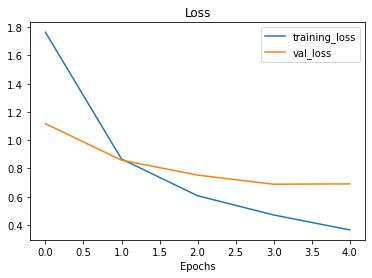

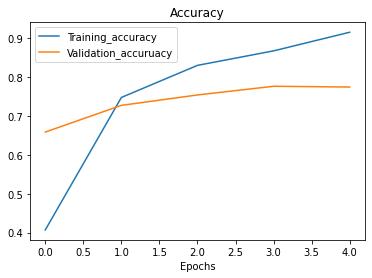

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model 
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes =train_data_10_percent.num_classes)

# Compile the model 
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              epochs = EPOCHS,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                       experiment_name = 'efficientnetb0')])

Saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20220717-18$M$S
Epoch 1/5
24/24 [==============================] - 198s 8s/step - loss: 1.7807 - accuracy: 0.4707 - val_loss: 1.2582 - val_accuracy: 0.7548
Epoch 2/5
24/24 [==============================] - 182s 8s/step - loss: 1.0327 - accuracy: 0.7907 - val_loss: 0.8559 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 165s 7s/step - loss: 0.7475 - accuracy: 0.8320 - val_loss: 0.6939 - val_accuracy: 0.8472
Epoch 4/5
24/24 [==============================] - 181s 8s/step - loss: 0.6015 - accuracy: 0.8707 - val_loss: 0.6094 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 167s 7s/step - loss: 0.5099 - accuracy: 0.8827 - val_loss: 0.5590 - val_accuracy: 0.8612


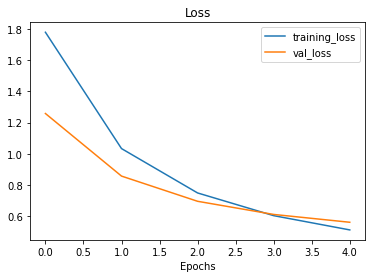

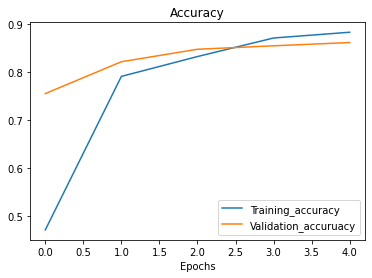

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* **"As is"** transfer learning - using an exsisting model with no changes what so ever

* **"Feature extraction"** transfer learning - use the prelearned patterns of an existiing model and adjust the output layer for your own problem (resnet, efficientnet)

* **"Fine Tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (incluuding new output layers)

## Comparing our models results using TensorBoard

**Note** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want other to see) do not upload them to TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/  \
    --name "EfficientNetB0 vs ResNet50V2" \
    --description "Comparing tow different TF Hub feture extraction model architecture using 10% of the training data" \
    --one_shot  

2022-07-17 18:46:55.843211: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%

In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id muDynAD9QGm4D8PWXzxCQA